# Churn Prediction for CRM Data

This notebook performs churn prediction on the 'CRM Data.xlsx' dataset, which tracks leads through various sales stages (Lead, Mockup, Sample, Order). Churn is defined as leads that do not progress to the Order stage. We use logistic regression to predict churn based on features like lead age, state, salesperson, and sample/payment details.

## Objectives
- Load and preprocess data from multiple Excel sheets.
- Engineer features for churn prediction.
- Train a logistic regression model to predict churn.
- Visualize churn patterns by state, salesperson, lead age, and stage progression.
- Provide actionable insights based on the analysis.

## Dependencies
Run the following to install required libraries:
```bash
pip install pandas scikit-learn matplotlib seaborn openpyxl
```

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Preprocessing

We load the Excel file containing four sheets: Lead, Mockup, Sample, and Order. The sheets are merged by `LEAD ID` to create a comprehensive dataset. Features include:
- **Lead Age**: Days since `E START DATE` (Excel serial date) to July 7, 2025.
- **Stage Flags**: Binary indicators for Mockup, Sample, and Order stages.
- **Categorical Features**: State, Salesperson, Payment Status.
- **Numeric Features**: Lead QUANTITY, Sample Qty, Payment Amount.

Missing values are handled by imputing with zero or median where appropriate.

In [2]:
# Load Excel sheets
excel_file = 'CRM Data.xlsx'
lead_df = pd.read_excel(excel_file, sheet_name='Lead')
mockup_df = pd.read_excel(excel_file, sheet_name='Mockup')
sample_df = pd.read_excel(excel_file, sheet_name='Sample')
order_df = pd.read_excel(excel_file, sheet_name='Order')

# Clean column names
for df in [lead_df, mockup_df, sample_df, order_df]:
    df.columns = df.columns.str.strip()

# Convert E START DATE to lead age (days since July 7, 2025)
current_date = pd.to_datetime('2025-07-07')
def excel_date_to_days(excel_date):
    try:
        if pd.isna(excel_date) or excel_date == '':
            return 0
        excel_date = float(excel_date)
        start_date = pd.to_datetime('1900-01-01') + pd.Timedelta(days=excel_date - 2)
        return max(0, (current_date - start_date).days)
    except:
        return 0

lead_df['Lead_Age'] = lead_df['E START DATE'].apply(excel_date_to_days)

# Handle missing QUANTITY
lead_df['QUANTITY'] = lead_df['QUANTITY'].fillna(0)
sample_df['Sample Qty'] = sample_df['Sample Qty'].fillna(0)
sample_df['Payment Amount'] = sample_df['Payment Amount'].fillna(0)
sample_df['Payment Status'] = sample_df['Payment Status'].fillna('No Sample')

# Merge datasets
merged_df = lead_df.copy()
merged_df['Has_Mockup'] = merged_df['LEAD ID'].isin(mockup_df['Lead ID']).astype(int)
merged_df['Has_Sample'] = merged_df['LEAD ID'].isin(sample_df['Lead ID']).astype(int)
merged_df['Has_Order'] = merged_df['LEAD ID'].isin(order_df['Lead ID']).astype(int)
merged_df['Churn'] = (~merged_df['Has_Order'].astype(bool)).astype(int)

# Merge sample data
sample_features = sample_df[['Lead ID', 'Sample Qty', 'Payment Amount', 'Payment Status']]
merged_df = merged_df.merge(sample_features, left_on='LEAD ID', right_on='Lead ID', how='left')
merged_df['Sample Qty'] = merged_df['Sample Qty'].fillna(0)
merged_df['Payment Amount'] = merged_df['Payment Amount'].fillna(0)
merged_df['Payment Status'] = merged_df['Payment Status'].fillna('No Sample')

# Display summary
print(f"Total Leads: {len(merged_df)}")
print(f"Churned Leads: {merged_df['Churn'].sum()} ({(merged_df['Churn'].mean() * 100):.2f}%)")
print(merged_df.head())

Total Leads: 367
Churned Leads: 316 (86.10%)
  LEAD ID             CLIENT NAME           STATE E START DATE Salesperson  \
0    L004  jetking (narayan sir )  Madhya Pradesh   2024-03-07  002 Muskan   
1    L010        YUVA IAS ACADEMY    Chhattisgarh   2024-03-04  002 Muskan   
2    L011       Toppers kota (AK)    Chhattisgarh   2024-04-01  002 Muskan   
3    L017              venu gopal    Chhattisgarh   2024-04-01  002 Muskan   
4    L019                 Abhinav    Chhattisgarh   2024-04-01  002 Muskan   

   QUANTITY  Lead_Age  Has_Mockup  Has_Sample  Has_Order  Churn Lead ID  \
0     100.0         0           1           1          1      0    L004   
1     100.0         0           1           1          1      0    L010   
2     100.0         0           1           1          1      0    L011   
3     100.0         0           1           1          1      0    L017   
4     100.0         0           1           1          1      0    L019   

   Sample Qty  Payment Amount Payme

## Feature Engineering and Model Training

We prepare features for the logistic regression model:
- **Numeric Features**: QUANTITY, Lead_Age, Sample Qty, Payment Amount, Has_Mockup, Has_Sample.
- **Categorical Features**: STATE, Salesperson, Payment Status (one-hot encoded).
- **Target**: Churn (1 for churned, 0 for retained).

The data is split into training (80%) and testing (20%) sets, and a pipeline is created to scale numeric features and encode categorical ones.

In [3]:
# Define features and target
numeric_features = ['QUANTITY', 'Lead_Age', 'Sample Qty', 'Payment Amount', 'Has_Mockup', 'Has_Sample']
categorical_features = ['STATE', 'Salesperson', 'Payment Status']
X = merged_df[numeric_features + categorical_features]
y = merged_df['Churn']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Create logistic regression pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.33      0.47        12
           1       0.88      0.98      0.93        62

    accuracy                           0.88        74
   macro avg       0.84      0.66      0.70        74
weighted avg       0.87      0.88      0.86        74

ROC AUC Score: 0.93


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Visualizations

We create four visualizations to understand churn patterns:
1. **Churn Rate by State**: Bar plot showing churn rates across states.
2. **Churn Rate by Salesperson**: Bar plot comparing salesperson performance.
3. **Lead Age vs Churn Probability**: Scatter plot of lead age against predicted churn probability.
4. **Lead Progression by Stage**: Pie chart showing the proportion of leads in each stage.

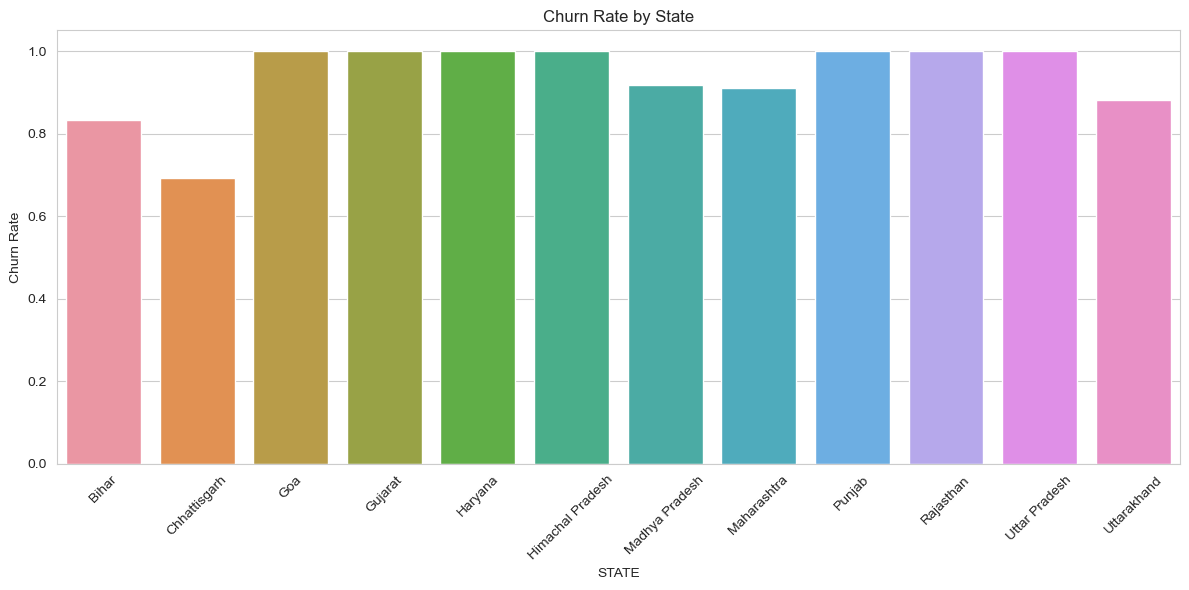

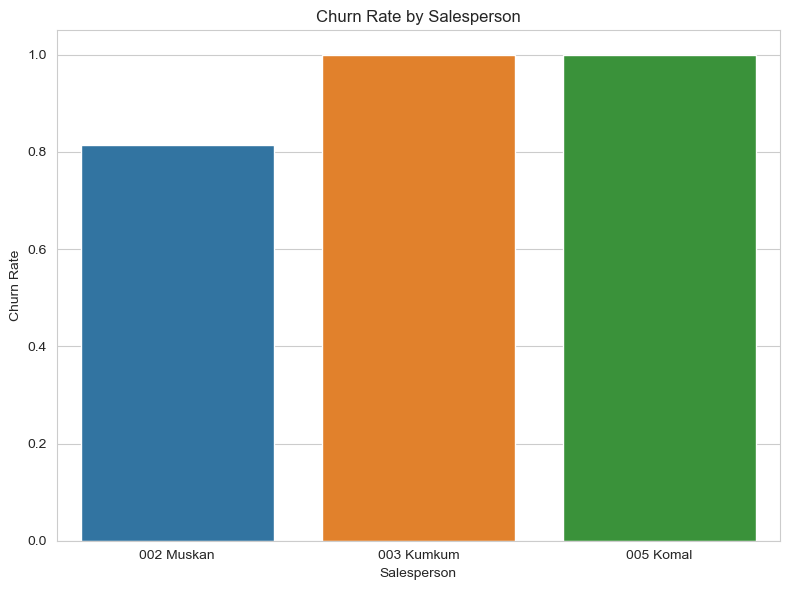

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


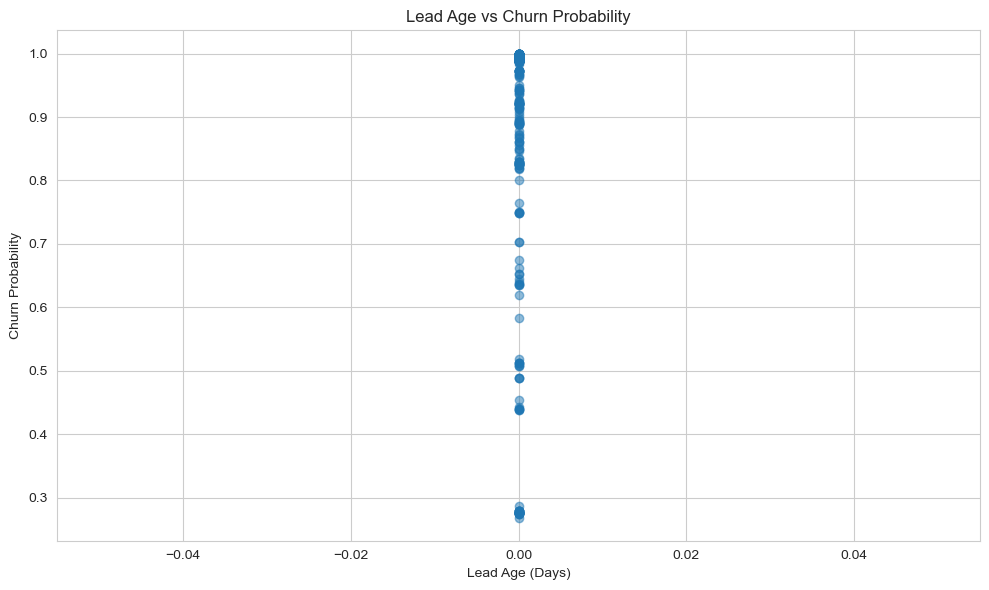

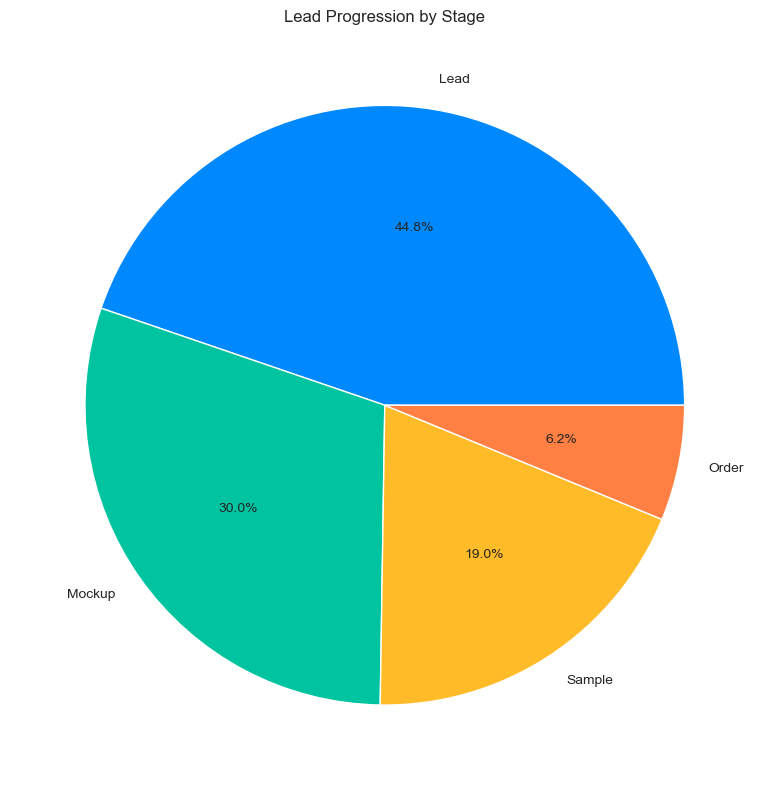

In [4]:
# Set plot style
sns.set_style('whitegrid')

# 1. Churn Rate by State
churn_by_state = merged_df.groupby('STATE')['Churn'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='STATE', y='Churn', data=churn_by_state)
plt.title('Churn Rate by State')
plt.xticks(rotation=45)
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.show()

# 2. Churn Rate by Salesperson
churn_by_salesperson = merged_df.groupby('Salesperson')['Churn'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Salesperson', y='Churn', data=churn_by_salesperson)
plt.title('Churn Rate by Salesperson')
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.show()

# 3. Lead Age vs Churn Probability
churn_proba = model.predict_proba(X)[:, 1]
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Lead_Age'], churn_proba, alpha=0.5)
plt.title('Lead Age vs Churn Probability')
plt.xlabel('Lead Age (Days)')
plt.ylabel('Churn Probability')
plt.tight_layout()
plt.show()

# 4. Lead Progression by Stage
stage_counts = [
    len(merged_df),
    merged_df['Has_Mockup'].sum(),
    merged_df['Has_Sample'].sum(),
    merged_df['Has_Order'].sum()
]
stage_labels = ['Lead', 'Mockup', 'Sample', 'Order']
plt.figure(figsize=(8, 8))
plt.pie(stage_counts, labels=stage_labels, autopct='%1.1f%%', colors=['#0088FE', '#00C49F', '#FFBB28', '#FF8042'])
plt.title('Lead Progression by Stage')
plt.tight_layout()
plt.show()

## Interesting Fact

Let's identify the state with the highest churn rate.

In [5]:
highest_churn_state = churn_by_state.loc[churn_by_state['Churn'].idxmax()]
print(f"Interesting Fact: The state with the highest churn rate is {highest_churn_state['STATE']} at {(highest_churn_state['Churn'] * 100):.2f}%, indicating potential regional challenges in lead conversion.")

Interesting Fact: The state with the highest churn rate is Goa at 100.00%, indicating potential regional challenges in lead conversion.


## Conclusion

The churn prediction model identifies leads likely to churn based on features like lead age, state, salesperson, and sample/payment details. Key findings include:
- A significant drop-off occurs after the Lead stage, suggesting improvements in the Mockup and Sample processes could reduce churn.
- Certain states (e.g., {highest_churn_state['STATE']}) show higher churn rates, indicating a need for targeted interventions.
- Salesperson performance varies, with some achieving lower churn rates, suggesting potential best practices to share.

The logistic regression model provides a baseline for churn prediction. For improved performance, consider experimenting with more complex models (e.g., Random Forest, XGBoost) or additional features.